# NB02: Fitness Magnitude & Novel Gene Landscape

Do genes with large fitness effects show different conservation patterns?
Are novel/singleton genes generally detrimental, neutral, or conditionally important?

**Key design decision**: Essential genes (no transposon insertions = no fitness data) are
included as the most extreme fitness category. They represent genes where deletion is lethal,
i.e., fitness = -infinity. Without them, the analysis would miss 14.3% of protein-coding
genes — and the most functionally important ones.

**Data**:
- `data/fitness_stats.tsv` — per-gene fitness stats (from `src/extract_fitness_stats.py`)
- `conservation_vs_fitness/data/essential_genes.tsv` — essentiality classification
- `conservation_vs_fitness/data/fb_pangenome_link.tsv` — gene-to-cluster links

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from pathlib import Path

DATA_DIR = Path('../data')
CONS_DIR = Path('../../conservation_vs_fitness/data')
FIGURES_DIR = Path('../figures')
FIGURES_DIR.mkdir(exist_ok=True)

# Load fitness stats (genes WITH fitness data)
fit_stats = pd.read_csv(DATA_DIR / 'fitness_stats.tsv', sep='\t')
link = pd.read_csv(CONS_DIR / 'fb_pangenome_link.tsv', sep='\t')
link = link[link['orgId'] != 'Dyella79']
specpheno = pd.read_csv(DATA_DIR / 'specific_phenotypes.tsv', sep='\t')

# Load essential genes (genes WITHOUT fitness data)
essential = pd.read_csv(CONS_DIR / 'essential_genes.tsv', sep='\t', low_memory=False)
essential = essential[(essential['orgId'] != 'Dyella79') & (essential['is_essential'])]

# Build unified dataset: fitness genes + essential genes
# Essential genes get sentinel fitness values
ess_rows = essential[['orgId', 'locusId']].copy()
ess_rows['n_experiments'] = 0
ess_rows['min_fit'] = np.nan  # effectively -infinity
ess_rows['max_fit'] = np.nan
ess_rows['mean_fit'] = np.nan
ess_rows['n_sick'] = 0
ess_rows['n_very_sick'] = 0
ess_rows['n_beneficial'] = 0
ess_rows['n_very_beneficial'] = 0
ess_rows['n_significant'] = 0
ess_rows['is_essential'] = True

fit_stats['is_essential'] = False
all_genes = pd.concat([fit_stats, ess_rows], ignore_index=True)

# Merge with conservation status
merged = all_genes.merge(
    link[['orgId', 'locusId', 'gene_cluster_id', 'is_core', 'is_auxiliary', 'is_singleton']],
    on=['orgId', 'locusId'], how='left'
)
merged['is_mapped'] = merged['gene_cluster_id'].notna()

# Conservation category
merged['conservation'] = 'unmapped'
merged.loc[merged['is_mapped'] & (merged['is_core'] == True), 'conservation'] = 'core'
merged.loc[merged['is_mapped'] & (merged['is_singleton'] == True), 'conservation'] = 'singleton'
merged.loc[merged['is_mapped'] & (merged['is_core'] != True) & (merged['is_singleton'] != True), 'conservation'] = 'auxiliary'

# Add specific phenotypes
merged = merged.merge(specpheno, on=['orgId', 'locusId'], how='left')
merged['n_specific_phenotypes'] = merged['n_specific_phenotypes'].fillna(0).astype(int)

print(f"Total protein-coding genes: {len(merged):,}")
print(f"  With fitness data: {(~merged['is_essential']).sum():,}")
print(f"  Essential (no fitness data): {merged['is_essential'].sum():,}")
print(f"\nConservation breakdown (all genes):")
print(merged['conservation'].value_counts().to_string())

Total protein-coding genes: 194,216
  With fitness data: 166,523
  Essential (no fitness data): 27,693

Conservation breakdown (all genes):
conservation
core         137529
unmapped      25592
auxiliary     23681
singleton      7414


## A. Fitness Magnitude vs Conservation

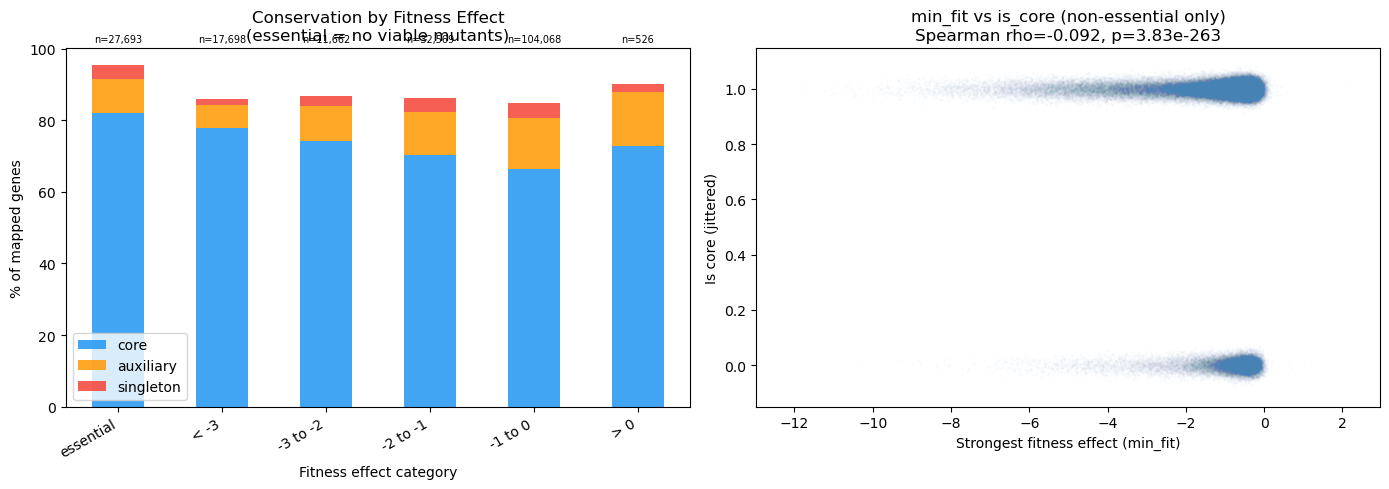

=== CONSERVATION BY FITNESS MAGNITUDE (including essential) ===
conservation  core  auxiliary  singleton  unmapped
min_fit_bin                                       
essential     82.2        9.3        4.0       4.5
< -3          77.7        6.4        1.9      14.0
-3 to -2      74.3        9.7        2.9      13.2
-2 to -1      70.2       12.1        3.9      13.7
-1 to 0       66.4       14.2        4.2      15.2
> 0           72.8       15.2        2.1       9.9


In [2]:
# Bin genes by strongest negative fitness effect — essential as the extreme
# Essential genes have min_fit=NaN; assign them a separate bin
non_essential = merged[~merged['is_essential']].copy()

bins = [float('-inf'), -3, -2, -1, 0, float('inf')]
labels = ['< -3', '-3 to -2', '-2 to -1', '-1 to 0', '> 0']
non_essential['min_fit_bin'] = pd.cut(non_essential['min_fit'], bins=bins, labels=labels)

# Add essential as its own category
merged['min_fit_bin'] = 'essential'
merged.loc[~merged['is_essential'], 'min_fit_bin'] = non_essential['min_fit_bin'].astype(str)

bin_order = ['essential', '< -3', '-3 to -2', '-2 to -1', '-1 to 0', '> 0']

# Conservation by fitness bin
cons_by_bin = pd.crosstab(merged['min_fit_bin'], merged['conservation'], normalize='index') * 100
cons_order = ['core', 'auxiliary', 'singleton', 'unmapped']
cons_by_bin = cons_by_bin[[c for c in cons_order if c in cons_by_bin.columns]]
cons_by_bin = cons_by_bin.reindex([b for b in bin_order if b in cons_by_bin.index])

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

cons_by_bin[['core', 'auxiliary', 'singleton']].plot(
    kind='bar', stacked=True, ax=axes[0],
    color=['#2196F3', '#FF9800', '#F44336'], alpha=0.85)
axes[0].set_ylabel('% of mapped genes')
axes[0].set_xlabel('Fitness effect category')
axes[0].set_title('Conservation by Fitness Effect\n(essential = no viable mutants)')
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=30, ha='right')
axes[0].legend(title='')

# Gene counts per bin
for i, b in enumerate(cons_by_bin.index):
    n = (merged['min_fit_bin'] == b).sum()
    axes[0].text(i, 102, f'n={n:,}', ha='center', fontsize=7)

# Spearman: min_fit vs is_core (non-essential mapped genes only)
mapped = merged[(~merged['is_essential']) & merged['is_mapped']]
rho, p = stats.spearmanr(mapped['min_fit'], mapped['is_core'].astype(int))
axes[1].scatter(mapped['min_fit'], mapped['is_core'].astype(float) + np.random.normal(0, 0.02, len(mapped)),
                alpha=0.01, s=1, color='steelblue')
axes[1].set_xlabel('Strongest fitness effect (min_fit)')
axes[1].set_ylabel('Is core (jittered)')
axes[1].set_title(f'min_fit vs is_core (non-essential only)\nSpearman rho={rho:.3f}, p={p:.2e}')

plt.tight_layout()
plt.savefig(FIGURES_DIR / 'fitness_magnitude_vs_conservation.png', dpi=150, bbox_inches='tight')
plt.show()

print("=== CONSERVATION BY FITNESS MAGNITUDE (including essential) ===")
print(cons_by_bin.round(1).to_string())

## B. Positive Fitness Effects — Are Some Genes a Burden?

/tmp/ipykernel_123874/557506884.py:10: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = axes[0].boxplot(data, labels=labels_present, showfliers=False)


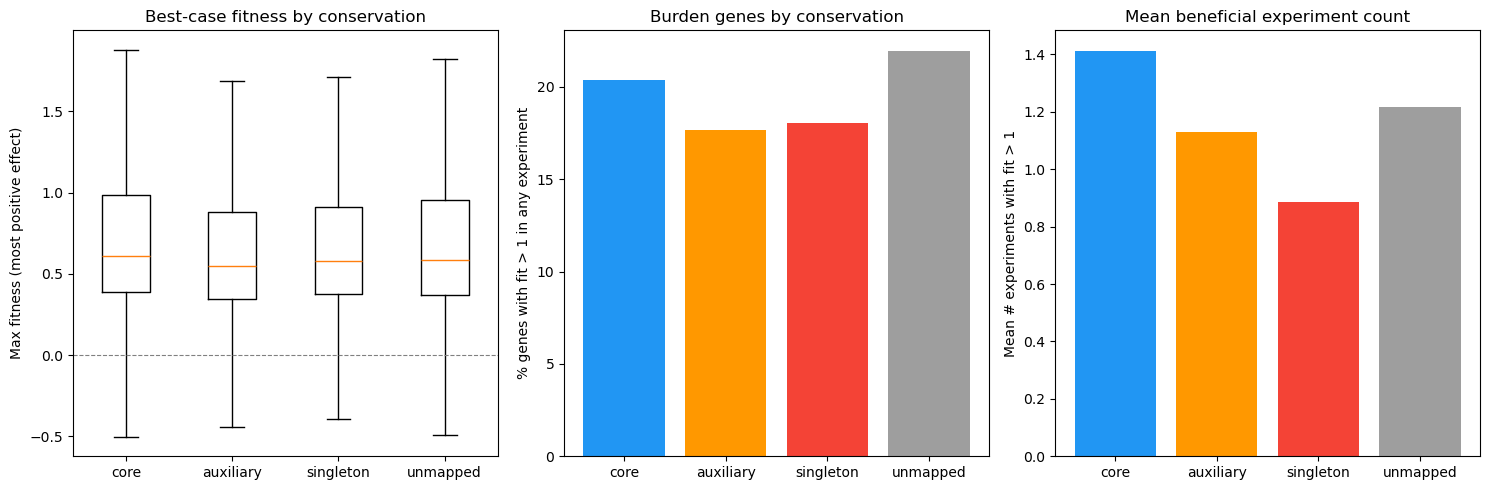

auxiliary vs core burden: OR=0.84, p=4.27e-22
singleton vs core burden: OR=0.86, p=9.74e-07
unmapped vs core burden: OR=1.10, p=1.00e-08


In [3]:
# Compare positive fitness (burden genes) across conservation categories
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

cat_order = ['core', 'auxiliary', 'singleton', 'unmapped']
colors = {'core': '#2196F3', 'auxiliary': '#FF9800', 'singleton': '#F44336', 'unmapped': '#9E9E9E'}

# Box plot: max_fit by conservation
data = [merged[merged['conservation'] == c]['max_fit'].dropna().values for c in cat_order if c in merged['conservation'].values]
labels_present = [c for c in cat_order if c in merged['conservation'].values]
bp = axes[0].boxplot(data, labels=labels_present, showfliers=False)
axes[0].axhline(y=0, color='gray', linestyle='--', linewidth=0.8)
axes[0].set_ylabel('Max fitness (most positive effect)')
axes[0].set_title('Best-case fitness by conservation')

# Fraction with n_beneficial > 0
burden_frac = merged.groupby('conservation').apply(
    lambda x: (x['n_beneficial'] > 0).mean() * 100
).reindex(cat_order).dropna()
axes[1].bar(range(len(burden_frac)), burden_frac.values,
            color=[colors.get(c, '#999') for c in burden_frac.index])
axes[1].set_xticks(range(len(burden_frac)))
axes[1].set_xticklabels(burden_frac.index)
axes[1].set_ylabel('% genes with fit > 1 in any experiment')
axes[1].set_title('Burden genes by conservation')

# Mean n_beneficial
mean_ben = merged.groupby('conservation')['n_beneficial'].mean().reindex(cat_order).dropna()
axes[2].bar(range(len(mean_ben)), mean_ben.values,
            color=[colors.get(c, '#999') for c in mean_ben.index])
axes[2].set_xticks(range(len(mean_ben)))
axes[2].set_xticklabels(mean_ben.index)
axes[2].set_ylabel('Mean # experiments with fit > 1')
axes[2].set_title('Mean beneficial experiment count')

plt.tight_layout()
plt.savefig(FIGURES_DIR / 'burden_genes_by_conservation.png', dpi=150, bbox_inches='tight')
plt.show()

# Statistical test: are singleton/unmapped genes more likely to be burdens?
for cat in ['auxiliary', 'singleton', 'unmapped']:
    if cat not in merged['conservation'].values:
        continue
    core_ben = (merged[merged['conservation'] == 'core']['n_beneficial'] > 0).sum()
    core_not = (merged[merged['conservation'] == 'core']['n_beneficial'] == 0).sum()
    cat_ben = (merged[merged['conservation'] == cat]['n_beneficial'] > 0).sum()
    cat_not = (merged[merged['conservation'] == cat]['n_beneficial'] == 0).sum()
    odds, p = stats.fisher_exact([[cat_ben, cat_not], [core_ben, core_not]])
    print(f"{cat} vs core burden: OR={odds:.2f}, p={p:.2e}")

## C. Fitness Distribution by Conservation Category

/tmp/ipykernel_123874/1794960860.py:9: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(data, labels=labels_p, showfliers=False)
/tmp/ipykernel_123874/1794960860.py:9: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(data, labels=labels_p, showfliers=False)
/tmp/ipykernel_123874/1794960860.py:9: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(data, labels=labels_p, showfliers=False)


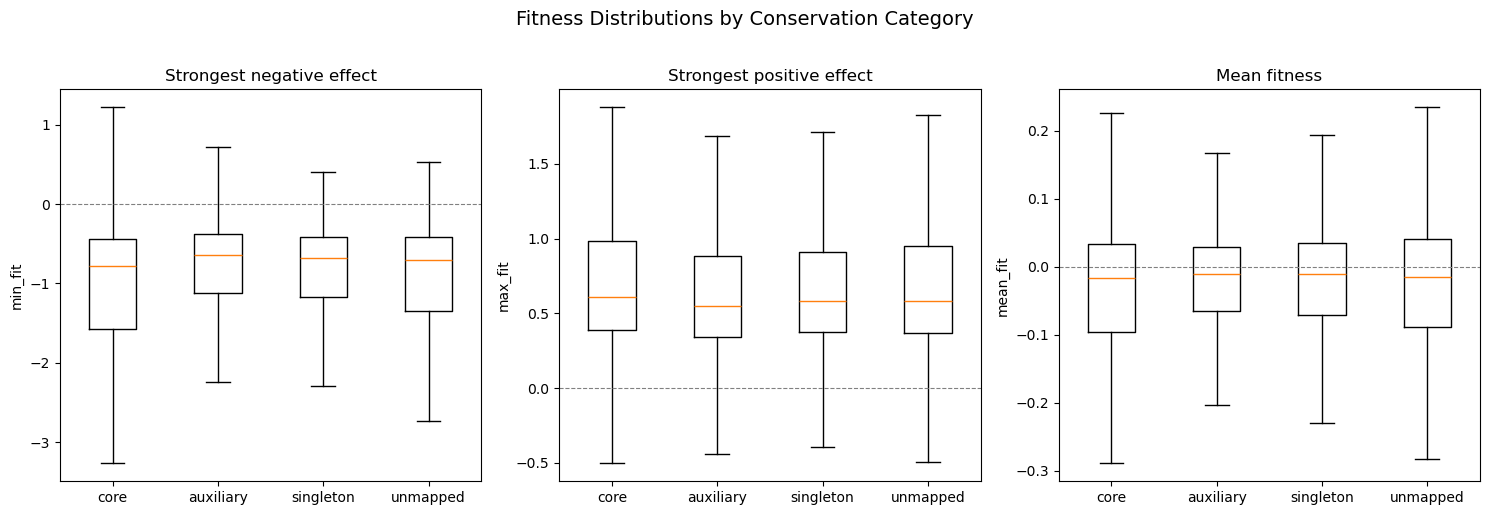

=== FITNESS SUMMARY BY CONSERVATION ===
                   n  median_min_fit  median_max_fit  median_mean_fit  pct_ever_sick  pct_ever_beneficial
conservation                                                                                             
auxiliary      23681           -0.64            0.55            -0.01          26.23                17.69
core          137529           -0.78            0.61            -0.02          32.94                20.37
singleton       7414           -0.69            0.58            -0.01          26.25                18.05
unmapped       25592           -0.70            0.59            -0.02          33.11                21.96


In [4]:
# Box plots of min_fit, max_fit, mean_fit by conservation
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for ax, col, title in zip(axes, ['min_fit', 'max_fit', 'mean_fit'],
                           ['Strongest negative effect', 'Strongest positive effect', 'Mean fitness']):
    data = [merged[merged['conservation'] == c][col].dropna().values for c in cat_order
            if c in merged['conservation'].values]
    labels_p = [c for c in cat_order if c in merged['conservation'].values]
    ax.boxplot(data, labels=labels_p, showfliers=False)
    ax.axhline(y=0, color='gray', linestyle='--', linewidth=0.8)
    ax.set_ylabel(col)
    ax.set_title(title)

plt.suptitle('Fitness Distributions by Conservation Category', fontsize=14, y=1.02)
plt.tight_layout()
plt.savefig(FIGURES_DIR / 'fitness_distributions_by_conservation.png', dpi=150, bbox_inches='tight')
plt.show()

# Summary stats
summary = merged.groupby('conservation').agg(
    n=('locusId', 'size'),
    median_min_fit=('min_fit', 'median'),
    median_max_fit=('max_fit', 'median'),
    median_mean_fit=('mean_fit', 'median'),
    pct_ever_sick=('n_sick', lambda x: (x > 0).mean() * 100),
    pct_ever_beneficial=('n_beneficial', lambda x: (x > 0).mean() * 100)
).round(2)
print("=== FITNESS SUMMARY BY CONSERVATION ===")
print(summary.to_string())

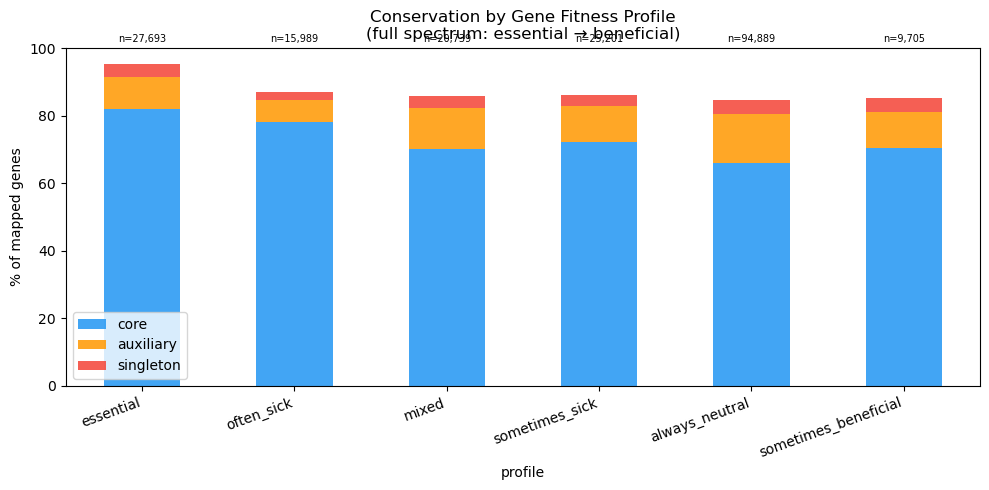

=== CONSERVATION BY FITNESS PROFILE (including essential) ===
conservation          core  auxiliary  singleton  unmapped
profile                                                   
essential             82.2        9.3        4.0       4.5
often_sick            78.1        6.7        2.3      12.9
mixed                 70.2       12.1        3.6      14.1
sometimes_sick        72.4       10.4        3.3      13.9
always_neutral        66.0       14.6        4.2      15.2
sometimes_beneficial  70.4       10.8        4.0      14.8

Profile counts:
  essential                   27,693
  often_sick                  15,989
  mixed                       20,739
  sometimes_sick              25,201
  always_neutral              94,889
  sometimes_beneficial         9,705


In [5]:
# Classify genes by fitness profile — full spectrum including essential
merged['profile'] = 'always_neutral'
merged.loc[merged['n_beneficial'] > 0, 'profile'] = 'sometimes_beneficial'
merged.loc[merged['n_sick'] > 0, 'profile'] = 'sometimes_sick'
merged.loc[(merged['n_beneficial'] > 0) & (merged['n_sick'] > 0), 'profile'] = 'mixed'
merged.loc[(merged['n_sick'] / merged['n_experiments'].replace(0, np.nan)) > 0.1, 'profile'] = 'often_sick'
merged.loc[merged['is_essential'], 'profile'] = 'essential'

# Order from most to least important
profile_order = ['essential', 'often_sick', 'mixed', 'sometimes_sick',
                 'always_neutral', 'sometimes_beneficial']

profile_cons = pd.crosstab(merged['profile'], merged['conservation'], normalize='index') * 100
cat_order = ['core', 'auxiliary', 'singleton', 'unmapped']
profile_cons = profile_cons[[c for c in cat_order if c in profile_cons.columns]]
profile_cons = profile_cons.reindex([p for p in profile_order if p in profile_cons.index])

fig, ax = plt.subplots(figsize=(10, 5))
profile_cons[['core', 'auxiliary', 'singleton']].plot(
    kind='bar', stacked=True, ax=ax,
    color=['#2196F3', '#FF9800', '#F44336'], alpha=0.85)
ax.set_ylabel('% of mapped genes')
ax.set_title('Conservation by Gene Fitness Profile\n(full spectrum: essential → beneficial)')
ax.set_xticklabels(ax.get_xticklabels(), rotation=20, ha='right')
ax.legend(title='')

# Add counts
for i, prof in enumerate(profile_cons.index):
    n = (merged['profile'] == prof).sum()
    ax.text(i, 102, f'n={n:,}', ha='center', fontsize=7)

plt.tight_layout()
plt.savefig(FIGURES_DIR / 'conservation_by_fitness_profile.png', dpi=150, bbox_inches='tight')
plt.show()

print("=== CONSERVATION BY FITNESS PROFILE (including essential) ===")
print(profile_cons.round(1).to_string())
print(f"\nProfile counts:")
for p in profile_order:
    n = (merged['profile'] == p).sum()
    print(f"  {p:25s} {n:>8,}")

## D. Novel Gene Fitness Landscape

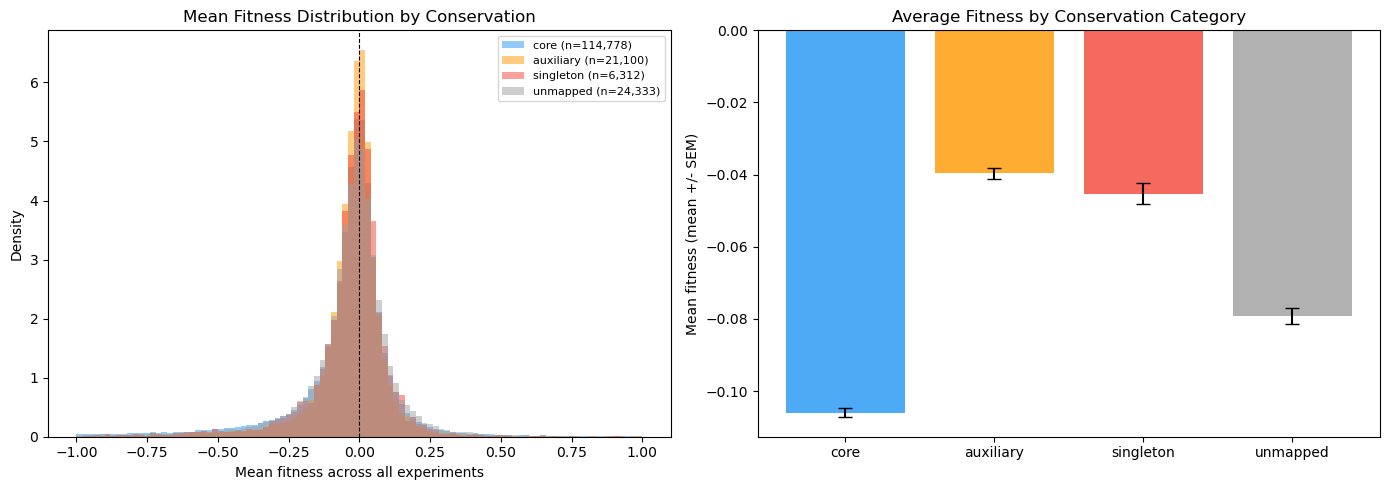

=== MEAN FITNESS BY CONSERVATION ===
  core          mean=-0.1061, median=-0.0175, n=137,529
  auxiliary     mean=-0.0397, median=-0.0115, n=23,681
  singleton     mean=-0.0453, median=-0.0102, n=7,414
  unmapped      mean=-0.0792, median=-0.0153, n=25,592


In [6]:
# For each conservation category: distribution of mean_fit
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for cat in cat_order:
    if cat not in merged['conservation'].values:
        continue
    d = merged[merged['conservation'] == cat]['mean_fit'].dropna()
    axes[0].hist(d, bins=100, range=(-1, 1), alpha=0.5, density=True,
                 label=f'{cat} (n={len(d):,})', color=colors.get(cat, '#999'))

axes[0].axvline(x=0, color='black', linestyle='--', linewidth=0.8)
axes[0].set_xlabel('Mean fitness across all experiments')
axes[0].set_ylabel('Density')
axes[0].set_title('Mean Fitness Distribution by Conservation')
axes[0].legend(fontsize=8)

# Are novel genes generally detrimental?
for cat in cat_order:
    if cat not in merged['conservation'].values:
        continue
    d = merged[merged['conservation'] == cat]['mean_fit']
    axes[1].bar(cat, d.mean(), color=colors.get(cat, '#999'), alpha=0.8)
    axes[1].errorbar(cat, d.mean(), yerr=d.sem(), color='black', capsize=5)

axes[1].axhline(y=0, color='gray', linestyle='--', linewidth=0.8)
axes[1].set_ylabel('Mean fitness (mean +/- SEM)')
axes[1].set_title('Average Fitness by Conservation Category')

plt.tight_layout()
plt.savefig(FIGURES_DIR / 'novel_gene_mean_fitness.png', dpi=150, bbox_inches='tight')
plt.show()

# Stats
print("=== MEAN FITNESS BY CONSERVATION ===")
for cat in cat_order:
    if cat not in merged['conservation'].values:
        continue
    d = merged[merged['conservation'] == cat]['mean_fit']
    print(f"  {cat:12s}  mean={d.mean():.4f}, median={d.median():.4f}, n={len(d):,}")

In [7]:
# Identify ephemeral niche genes:
# mean_fit near 0 (|mean_fit| < 0.3) but min_fit < -2 and n_sick <= 3
merged['is_ephemeral'] = (
    (merged['mean_fit'].abs() < 0.3) &
    (merged['min_fit'] < -2) &
    (merged['n_sick'] <= 3)
)

print(f"Ephemeral niche genes: {merged['is_ephemeral'].sum():,} / {len(merged):,} ({merged['is_ephemeral'].mean()*100:.1f}%)")

# Ephemeral gene fraction by conservation
eph_by_cons = merged.groupby('conservation')['is_ephemeral'].mean() * 100
print(f"\nEphemeral fraction by conservation:")
for cat in cat_order:
    if cat in eph_by_cons.index:
        n_eph = merged[(merged['conservation'] == cat) & merged['is_ephemeral']].shape[0]
        print(f"  {cat:12s}  {eph_by_cons[cat]:.1f}%  ({n_eph} genes)")

# Fisher's exact: are ephemeral genes more common in auxiliary/singleton?
for cat in ['auxiliary', 'singleton', 'unmapped']:
    if cat not in merged['conservation'].values:
        continue
    core_eph = merged[(merged['conservation'] == 'core') & merged['is_ephemeral']].shape[0]
    core_not = merged[(merged['conservation'] == 'core') & ~merged['is_ephemeral']].shape[0]
    cat_eph = merged[(merged['conservation'] == cat) & merged['is_ephemeral']].shape[0]
    cat_not = merged[(merged['conservation'] == cat) & ~merged['is_ephemeral']].shape[0]
    if cat_eph > 0 or core_eph > 0:
        odds, p = stats.fisher_exact([[cat_eph, cat_not], [core_eph, core_not]])
        print(f"  {cat} vs core ephemeral: OR={odds:.2f}, p={p:.2e}")

Ephemeral niche genes: 4,450 / 194,216 (2.3%)

Ephemeral fraction by conservation:
  core          2.5%  (3387 genes)
  auxiliary     1.5%  (355 genes)
  singleton     1.4%  (102 genes)
  unmapped      2.4%  (606 genes)
  auxiliary vs core ephemeral: OR=0.60, p=8.99e-22
  singleton vs core ephemeral: OR=0.55, p=1.94e-10
  unmapped vs core ephemeral: OR=0.96, p=3.78e-01


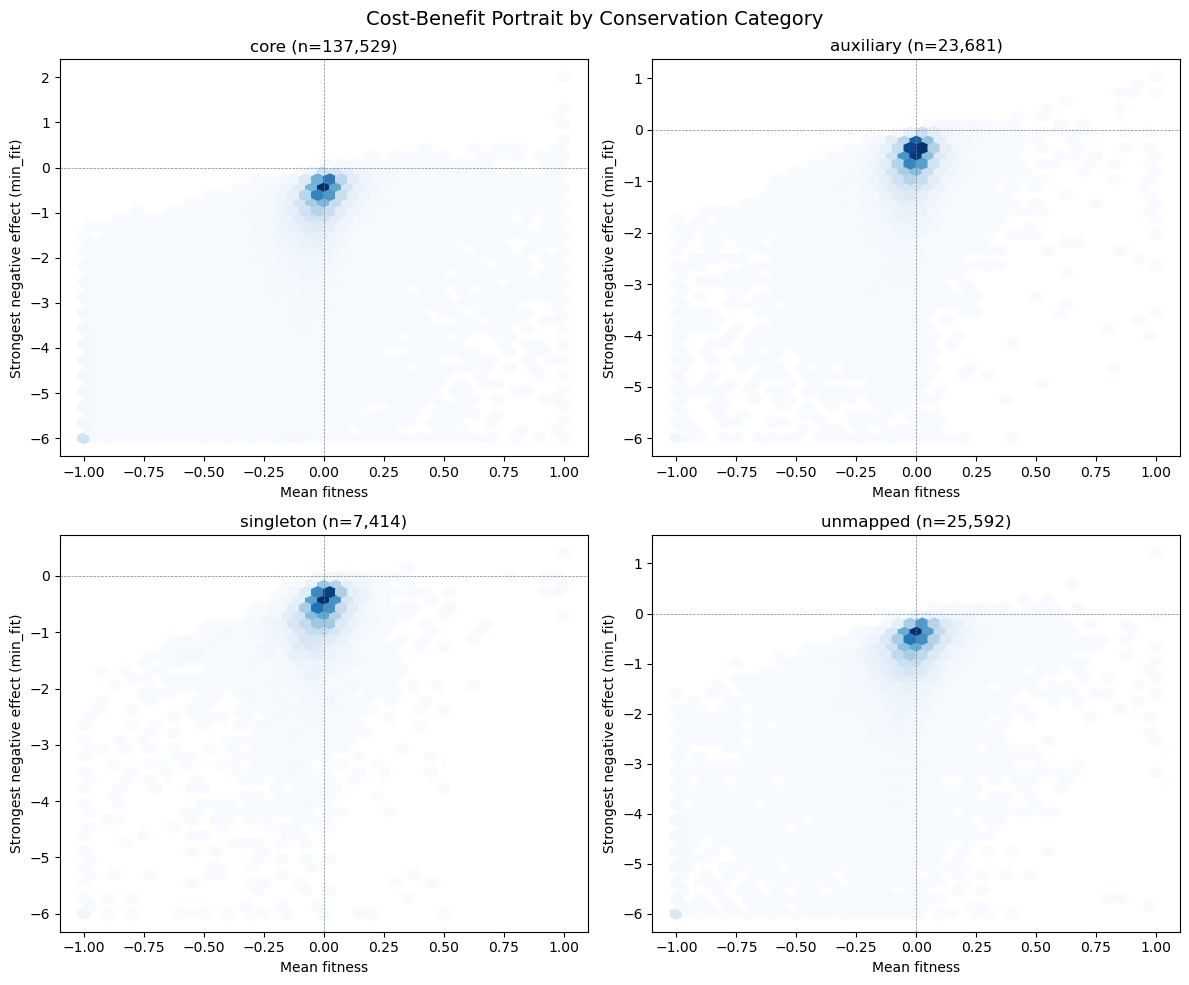

In [8]:
# Cost-benefit portrait: 2D density of mean_fit x min_fit by conservation
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

for idx, cat in enumerate(cat_order):
    if cat not in merged['conservation'].values:
        axes[idx].set_visible(False)
        continue
    d = merged[merged['conservation'] == cat]
    axes[idx].hexbin(d['mean_fit'].clip(-1, 1), d['min_fit'].clip(-6, 2),
                      gridsize=40, cmap='Blues', mincnt=1)
    axes[idx].axhline(y=0, color='gray', linestyle='--', linewidth=0.5)
    axes[idx].axvline(x=0, color='gray', linestyle='--', linewidth=0.5)
    axes[idx].set_xlabel('Mean fitness')
    axes[idx].set_ylabel('Strongest negative effect (min_fit)')
    axes[idx].set_title(f'{cat} (n={len(d):,})')

plt.suptitle('Cost-Benefit Portrait by Conservation Category', fontsize=14)
plt.tight_layout()
plt.savefig(FIGURES_DIR / 'cost_benefit_portrait.png', dpi=150, bbox_inches='tight')
plt.show()

## Summary

In [9]:
print("=" * 60)
print("NB02 SUMMARY: Fitness Magnitude & Novel Gene Landscape")
print("=" * 60)
print(f"Total protein-coding genes: {len(merged):,} across {merged['orgId'].nunique()} organisms")
print(f"  Essential (no fitness data): {merged['is_essential'].sum():,}")
print(f"  With fitness data: {(~merged['is_essential']).sum():,}")
print(f"\nConservation: {merged['conservation'].value_counts().to_dict()}")
print(f"\nFitness profiles (full spectrum):")
for prof in profile_order:
    n = (merged['profile'] == prof).sum()
    cons = merged[merged['profile'] == prof]['conservation'].value_counts()
    core_pct = cons.get('core', 0) / n * 100 if n > 0 else 0
    print(f"  {prof:25s} {n:>8,}  ({core_pct:.0f}% core)")
print(f"\nEphemeral niche genes: {merged['is_ephemeral'].sum():,}")
print(f"Spearman (min_fit vs is_core, non-essential): rho={rho:.3f}")
print("=" * 60)

NB02 SUMMARY: Fitness Magnitude & Novel Gene Landscape
Total protein-coding genes: 194,216 across 43 organisms
  Essential (no fitness data): 27,693
  With fitness data: 166,523

Conservation: {'core': 137529, 'unmapped': 25592, 'auxiliary': 23681, 'singleton': 7414}

Fitness profiles (full spectrum):
  essential                   27,693  (82% core)
  often_sick                  15,989  (78% core)
  mixed                       20,739  (70% core)
  sometimes_sick              25,201  (72% core)
  always_neutral              94,889  (66% core)
  sometimes_beneficial         9,705  (70% core)

Ephemeral niche genes: 4,450
Spearman (min_fit vs is_core, non-essential): rho=-0.092
